In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size()[0], -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)

In [3]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0

    with torch.no_grad(): 
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_loss += loss.item() * inputs.size(0)
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples * 100

    return avg_loss, accuracy

def compute_sensitivity(inputs, model, criterion):
    inputs.requires_grad_()
    outputs = model(inputs)
    loss = criterion(outputs, outputs.max(1)[1])
    loss.backward()
    sensitivity = torch.sqrt(torch.sum(inputs.grad ** 2))
    return sensitivity.item()

def train_model(model, optimizer, trainloader, testloader, epochs=5):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    sensitivities = []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total, sensitivity_accum = 0.0, 0, 0, 0.0
        
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            inputs.requires_grad = True  
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            sensitivity = compute_sensitivity(inputs, model, criterion)
            sensitivity_accum += sensitivity
            
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_sensitivity = sensitivity_accum / len(trainloader)
        sensitivities.append(epoch_sensitivity)
        
        train_losses.append(running_loss / len(trainloader))
        train_accuracies.append(100. * correct / total)

        test_loss, test_accuracy = evaluate_model(model, testloader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f"Epoch {epoch+1}, Sensitivity: {epoch_sensitivity}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Loss: {test_losses[-1]}, Test Accuracy: {test_accuracies[-1]}")

    return train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1], sensitivities[-1]

In [4]:
def load_data(train_batch_size, test_batch_size):
    transform = transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(),transforms.Normalize((0.1309,), (0.3083,))])

    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True)

    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False)

    return (trainloader, testloader)



In [5]:
batch_train_loss = []
batch_test_loss = []
batch_train_acc = []
batch_test_acc = []
batch_sensitivity = []

batch_size = [
    [16, 32, 64, 128, 256, 512],
    [32, 64, 128, 256, 512, 1024],
    [64, 128, 256, 512, 1024],
    [128, 256, 512, 1024, 2048],
    [256, 512, 1024, 2048, 4096]
]
for batch_sizes in batch_size:
    criterion = nn.CrossEntropyLoss()
    model = CNN_Model()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    final_train_loss = []
    final_test_loss = []
    final_train_acc = []
    final_test_acc = []
    final_sensitivity = []
    for i in batch_sizes:
        train_loader, test_loader = load_data(i, i)
        train_loss, test_loss, train_acc, test_acc, sens = train_model(model, optimizer, train_loader, test_loader)
        final_train_loss.append(train_loss)
        final_test_loss.append(test_loss)
        final_train_acc.append(train_acc)
        final_test_acc.append(test_acc)
        final_sensitivity.append(sens)
    batch_train_loss.append(final_train_loss)
    batch_test_loss.append(final_test_loss)
    batch_train_acc.append(final_train_acc)
    batch_test_acc.append(final_test_acc)
    batch_sensitivity.append(final_sensitivity)
    

Epoch 1, Sensitivity: 0.3050513659158295, Train Loss: 0.23007180228044405, Train Accuracy: 93.475, Test Loss: 0.11922116118601407, Test Accuracy: 96.32
Epoch 2, Sensitivity: 0.4401269000381737, Train Loss: 0.15661884500908205, Train Accuracy: 95.92166666666667, Test Loss: 0.12406961325350158, Test Accuracy: 96.97
Epoch 3, Sensitivity: 0.5953598990273599, Train Loss: 0.14726625693602918, Train Accuracy: 96.45, Test Loss: 0.1819776060407021, Test Accuracy: 95.45
Epoch 4, Sensitivity: 0.6171379724953558, Train Loss: 0.14170272401387438, Train Accuracy: 96.58833333333334, Test Loss: 0.11794318704336942, Test Accuracy: 97.18
Epoch 5, Sensitivity: 0.6667388245947782, Train Loss: 0.13387675935324725, Train Accuracy: 96.84, Test Loss: 0.13200441718948713, Test Accuracy: 96.36
Epoch 1, Sensitivity: 0.44559439815163304, Train Loss: 0.08653850665266534, Train Accuracy: 97.79, Test Loss: 0.11090115862952371, Test Accuracy: 97.28999999999999
Epoch 2, Sensitivity: 0.45782012276999495, Train Loss: 0.

Epoch 2, Sensitivity: 0.0911896267621699, Train Loss: 0.08150598233155275, Train Accuracy: 97.55, Test Loss: 0.11449454345703125, Test Accuracy: 96.93
Epoch 3, Sensitivity: 0.09315584132731972, Train Loss: 0.08130872344314041, Train Accuracy: 97.615, Test Loss: 0.12365575139522553, Test Accuracy: 96.86
Epoch 4, Sensitivity: 0.09056805781388687, Train Loss: 0.08086407238270267, Train Accuracy: 97.595, Test Loss: 0.1146093653678894, Test Accuracy: 96.85000000000001
Epoch 5, Sensitivity: 0.09250984413517734, Train Loss: 0.07812620247950998, Train Accuracy: 97.61333333333333, Test Loss: 0.12543566904067993, Test Accuracy: 96.99
Epoch 1, Sensitivity: 0.0656468349871999, Train Loss: 0.07284295514731084, Train Accuracy: 97.885, Test Loss: 0.12008409135341644, Test Accuracy: 97.04
Epoch 2, Sensitivity: 0.06572180108751281, Train Loss: 0.07316970193790177, Train Accuracy: 97.82333333333334, Test Loss: 0.11742906597852706, Test Accuracy: 97.00999999999999
Epoch 3, Sensitivity: 0.0648169447431119

Epoch 4, Sensitivity: 0.0, Train Loss: 2.7510628417386847, Train Accuracy: 10.218333333333334, Test Loss: 2.7565587394714357, Test Accuracy: 10.100000000000001
Epoch 5, Sensitivity: 0.0, Train Loss: 2.752720901521586, Train Accuracy: 10.218333333333334, Test Loss: 2.7452800872802734, Test Accuracy: 10.100000000000001
Epoch 1, Sensitivity: 0.0, Train Loss: 2.7502121210098265, Train Accuracy: 10.218333333333334, Test Loss: 2.750873221588135, Test Accuracy: 10.100000000000001
Epoch 2, Sensitivity: 0.0, Train Loss: 2.752540119489034, Train Accuracy: 10.218333333333334, Test Loss: 2.7586721324920656, Test Accuracy: 10.100000000000001
Epoch 3, Sensitivity: 0.0, Train Loss: 2.7502553939819334, Train Accuracy: 10.218333333333334, Test Loss: 2.76204016456604, Test Accuracy: 10.100000000000001
Epoch 4, Sensitivity: 0.0, Train Loss: 2.7525465567906697, Train Accuracy: 10.218333333333334, Test Loss: 2.744778274154663, Test Accuracy: 10.100000000000001
Epoch 5, Sensitivity: 0.0, Train Loss: 2.75226

[16, 32, 64, 128, 256, 512] [0.13387675935324725, 0.08749401410808638, 0.05549561694985849, 0.037024079801758376, 0.013549763085834552, 0.006220456150728396]


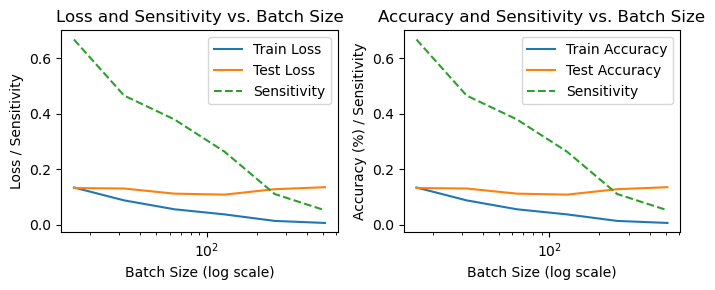

[32, 64, 128, 256, 512, 1024] [0.18001569030989584, 0.1381761792785069, 0.11411775897807086, 0.09201068927315956, 0.07812620247950998, 0.07076613074642117]


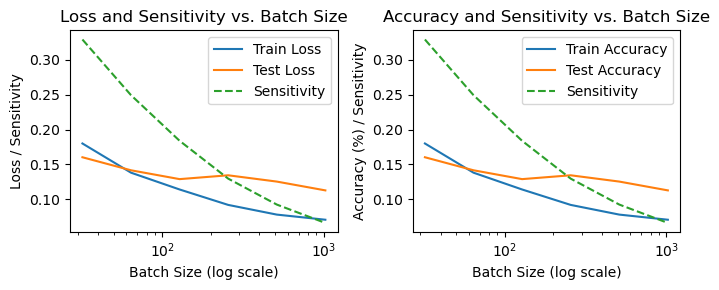

[64, 128, 256, 512, 1024] [0.15479384080421474, 0.08716194422941392, 0.05938678421872728, 0.03778406785074937, 0.025332388144491586]


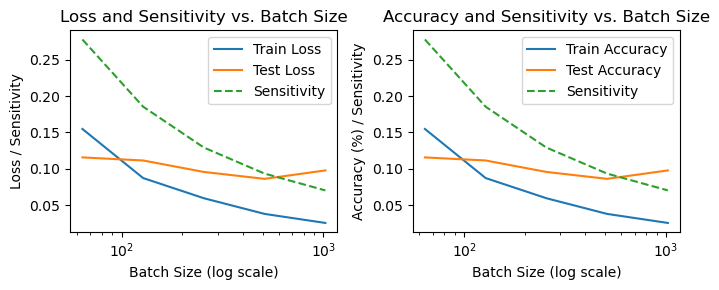

[128, 256, 512, 1024, 2048] [2.752290204643949, 2.751723815025167, 2.751142564466444, 2.752720901521586, 2.752264444033305]


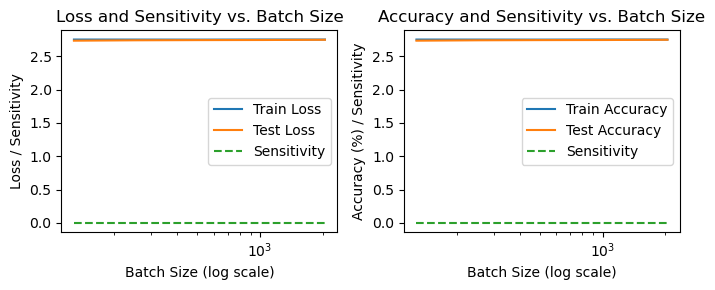

[256, 512, 1024, 2048, 4096] [0.09276483172273382, 0.05890997159847264, 0.039516831132567536, 0.029441542613009613, 0.02493408148487409]


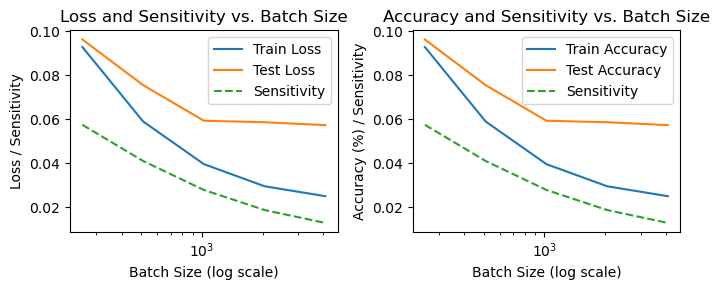

In [12]:
for i in range(len(batch_size)):
    plt.figure(figsize=(7, 3))
    plt.subplot(1, 2, 1)
    plt.plot(batch_size[i], batch_train_loss[i], label='Train Loss')
    plt.plot(batch_size[i], batch_test_loss[i], label='Test Loss')
    plt.plot(batch_size[i], batch_sensitivity[i], label='Sensitivity', linestyle='--')
    plt.xscale('log')
    plt.xlabel('Batch Size (log scale)')
    plt.ylabel('Loss / Sensitivity')
    plt.title('Loss and Sensitivity vs. Batch Size')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(batch_size[i], batch_train_loss[i], label='Train Accuracy')
    plt.plot(batch_size[i], batch_test_loss[i], label='Test Accuracy')
    plt.plot(batch_size[i], batch_sensitivity[i], label='Sensitivity', linestyle='--')
    plt.xscale('log')
    plt.xlabel('Batch Size (log scale)')
    plt.ylabel('Accuracy (%) / Sensitivity')
    plt.title('Accuracy and Sensitivity vs. Batch Size')
    plt.legend()

    plt.tight_layout()
    plt.show()